## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
from keras.layers import Dropout
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = [1e-2,1e-3,1e-4]
EPOCHS = 30
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [9]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for lr in LEARNING_RATE:
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=lr, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    exp_name_tag = "exp-lr-%s" % str(lr)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512       
__________

Epoch 9/30
50000/50000 [==============================] - 12s 241us/step - loss: 1.3388 - acc: 0.5346 - val_loss: 1.4995 - val_acc: 0.4785
Epoch 10/30
50000/50000 [==============================] - 12s 239us/step - loss: 1.3084 - acc: 0.5462 - val_loss: 1.4938 - val_acc: 0.4786
Epoch 11/30
50000/50000 [==============================] - 12s 241us/step - loss: 1.2814 - acc: 0.5584 - val_loss: 1.4929 - val_acc: 0.4766
Epoch 12/30
50000/50000 [==============================] - 12s 245us/step - loss: 1.2539 - acc: 0.5680 - val_loss: 1.4842 - val_acc: 0.4816
Epoch 13/30
50000/50000 [==============================] - 12s 243us/step - loss: 1.2283 - acc: 0.5775 - val_loss: 1.4768 - val_acc: 0.4816
Epoch 14/30
50000/50000 [==============================] - 12s 241us/step - loss: 1.2038 - acc: 0.5871 - val_loss: 1.4697 - val_acc: 0.4894
Epoch 15/30
50000/50000 [==============================] - 12s 245us/step - loss: 1.1812 - acc: 0.5952 - val_loss: 1.4670 - val_acc: 0.4875
Epoch 16/30
50000/500

50000/50000 [==============================] - 13s 269us/step - loss: 1.5043 - acc: 0.4767 - val_loss: 1.6287 - val_acc: 0.4251
Epoch 28/30
50000/50000 [==============================] - 13s 270us/step - loss: 1.4963 - acc: 0.4804 - val_loss: 1.6248 - val_acc: 0.4245
Epoch 29/30
50000/50000 [==============================] - 14s 270us/step - loss: 1.4886 - acc: 0.4825 - val_loss: 1.6199 - val_acc: 0.4288
Epoch 30/30
50000/50000 [==============================] - 14s 276us/step - loss: 1.4811 - acc: 0.4844 - val_loss: 1.6156 - val_acc: 0.4307


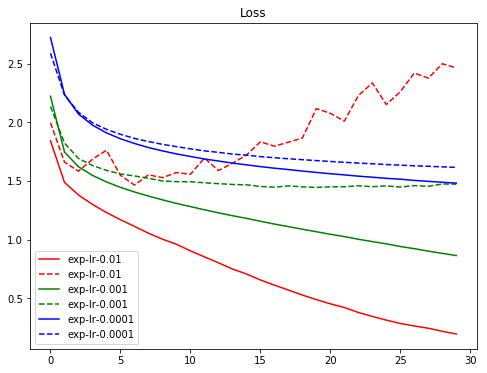

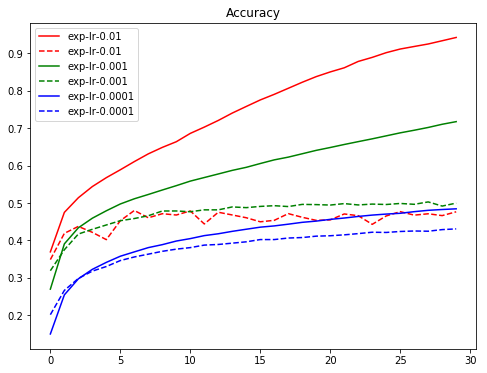

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()